In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from fastai2.vision.all import *
from torchvision import models

In [ ]:
path  = '/Users/rahulsomani/Desktop/shot-framing/'
dls1  = ImageDataLoaders.from_folder(
    path, bs=64, item_tmfs=[Resize((224,224), method=ResizeMethod.Squish, pad_mode=PadMode.Zeros)],
    batch_tfms = Normalize.from_stats(*imagenet_stats)
)

head1  = create_head(1280, 15, concat_pool=False)
learn1 = cnn_learner(dls, models.mobilenet_v2, cut=-1,
                     config={'custom_head': head1})

path  = '/Users/rahulsomani/Desktop/shot-framing/'
dls2  = ImageDataLoaders.from_folder(
    path, bs=64, item_tmfs=[Resize((224,224), method=ResizeMethod.Squish, pad_mode=PadMode.Zeros)],
    batch_tfms = Normalize.from_stats(*imagenet_stats)
)

head2  = create_head(1280, 15, concat_pool=False)
learn2 = cnn_learner(dls, models.mobilenet_v2, cut=-1,
                     config={'custom_head': head2})

In [ ]:
!ls /Users/rahulsomani/Downloads/framing*

/Users/rahulsomani/Downloads/framing-finetuned-224x224.pth
/Users/rahulsomani/Downloads/framing-finetuned_224x224_heavy-aug_accuracy.pth
/Users/rahulsomani/Downloads/framing-frozen-224x224.pth
/Users/rahulsomani/Downloads/framing-no_big-closeup-MILD-jitter_blur_accuracy.pth
/Users/rahulsomani/Downloads/framing-no_big-closeup_accuracy.pth


In [ ]:
learn1.path = Path('/Users/rahulsomani/Downloads/')
learn1.model_dir = '.'
learn1.load('framing-no_big-closeup_accuracy')

learn2.path = Path('/Users/rahulsomani/Downloads/')
learn2.model_dir = '.'
learn2.load('framing-no_big-closeup-MILD-jitter_blur_accuracy')
#learn.load('framing-finetuned_224x224_heavy-aug_accuracy')

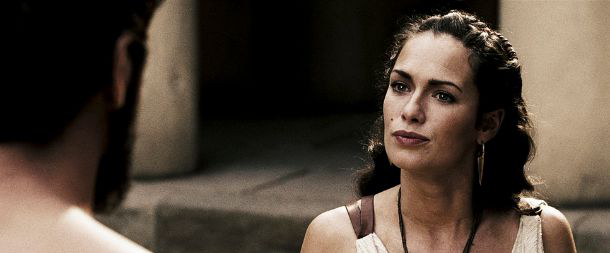

In [ ]:
import PIL
from PIL import Image
fname = '/Users/rahulsomani/Desktop/shot-type/tmp-OTS-valid/shot_type_overtheshoulder/300__2007__029_cropped.jpg'
img   = Image.open(fname)
img


In [ ]:
import torchvision.transforms as Tfms

preprocess = Tfms.Compose([
    Tfms.Resize((224,224)),
    Tfms.ToTensor(),
    Tfms.Normalize(*imagenet_stats),
])
preprocess

Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
color = lambda r,g,b: f'rgb({r},{g},{b})'

from PIL import ImageDraw, ImageFont
def draw(img:PIL.Image.Image,
         labels:list,
         font_size:float=None,
         font_color:Union[tuple,int] = (220,220,220),
         font_path  = '../fonts/DIN Alternate Bold.ttf',
         location   = 'bottom'
        ) -> PIL.Image.Image:
    draw = ImageDraw.Draw(img)
    if font_size is None: font_size = int(img.height/15)
    fcolor = color(*font_color)
    font   = ImageFont.truetype(font_path, size=font_size)
    
    if location=='bottom':
        draw.rectangle(xy=((0,img.height-(1.1*len(labels)*font_size*1.5)),
                           (img.width,img.height)),
                       fill='black')

    for i,label in enumerate(labels):
        if location=='bottom':
            w,h = draw.textsize(label)
            xy = ((img.width-w)/2, (img.height-(i+1)*font_size*1.5))
            #xy = ((img.width/2)-w, (img.height-(i+1)*font_size*1.5))
        else:
            if i==0: y=1
            else:    y=(i*font_size*1.5)
            xy = (10,y)
        draw.text(xy, text=label, fill=fcolor, font=font)
    return img

In [ ]:
from pprint import pprint
import torchvision.transforms as Tfms
from typing import Callable,List

preprocess = Tfms.Compose([
    Tfms.Resize((224,224), interpolation=PIL.Image.BILINEAR),
    Tfms.ToTensor(),
    Tfms.Normalize(*imagenet_stats)
])

class Identity():
    def __init__(self):
        pass
    def __call__(self,x):
        return x
    def __repr__(self):
        return 'Identity()'

def org_label(x):
    if isinstance(x, str): return np.array([x])
    return x.flatten()

class Predictor():
    def __init__(self, model, activation=None, preprocessor:Callable=None,
                 img_size=(224,224), interpolation=PIL.Image.BILINEAR, top_k:int=1,
                 norm_stats:Collection=imagenet_stats, classes:Collection=None):
        """
        """
        assert classes is not None, f"Enter list of output classes"
        self.model = model
        self.model.eval()
        if torch.cuda.is_available(): self.model = self.model.cuda()
        self.act_func = activation if activation is not None else Identity()
        if preprocessor is None:
            self.preprocessor = Tfms.Compose([
                Tfms.Resize(img_size, interpolation),
                Tfms.ToTensor(),
                Tfms.Normalize(*norm_stats)
            ])
        else: self.preprocessor = preprocessor
        self.topk    = top_k
        self.classes = classes
    
    def __call__(self, f:[str,Path,PIL.Image.Image], top_k=None, return_raw_preds=False):
        """
        """
        if isinstance(f, PIL.Image.Image): img=f.convert('RGB')
        else: img = Image.open(f).convert('RGB')
        
        topk = top_k if top_k is not None else self.topk
        
        x = self.preprocessor(img)
        x = x.cuda if torch.cuda.is_available() else x
        x = x.unsqueeze(0)
        
        preds = self.act_func(self.model(x))
        top_preds = preds.topk(topk)
        
        confidence = top_preds.values.detach().numpy().flatten()
        labels     = org_label(np.array(self.classes)[top_preds.indices])
        
        return img,confidence,labels
    
    def pretty_predict_str(self,
                           f:[str,Path,PIL.Image.Image],
                           pretty_predictor:Callable=None,
                           top_k=2):
        if pretty_predictor is None: pretty_predictor=Identity()
        img,confs,labels = self(f, top_k=top_k)
        res = pretty_predictor(confs,labels)
        return img,res
    
    def pretty_predict(self,f:[str,Path,PIL.Image.Image],
                       pretty_predictor:Callable=None,top_k=2,
                       oneline=True, oneline_sep=' | '):
        img,labels = self.pretty_predict_str(f, top_k=top_k,
                                             pretty_predictor=pretty_predictor)
        if oneline:
            #print((labels))
            labels = [' | '.join(labels)] if len(labels)>1 else labels
        return draw(img,labels)
    
    def __repr__(self):
        taxonomy = '\n'.join(self.classes)
        repr_str = f'''
     Model Taxonomy
-------------------------
{taxonomy}
        
      Preprocessing
-------------------------
{self.preprocessor}

   Activation Function
-------------------------
{self.act_func}
        '''
        return repr_str

In [ ]:
InteractiveShell.ast_node_interactivity='last_expr'

In [ ]:
predict_noblur = Predictor(learn1.model, nn.Softmax(-1), classes=list(learn1.dls.vocab), top_k=3)
predict_blur   = Predictor(learn2.model, nn.Softmax(-1), classes=list(learn2.dls.vocab), top_k=3)

In [ ]:
def lbl_fmt(x):
    lbl_dict = {
        '01-extremewide':       'Extreme Wide',
        '02-wide':              'Wide',
        '03-long':              'Long',
        '04-medium_long':       'Medium Long',
        '05-medium':            'Medium',
        '06-medium-close-up':   'Medium Close Up',
        '07-closeup-face':      'Close Up (Face)',
        #'08-big-closeup-face':  'Big Close Up (Face)',
        '09-cu-ecu-lower-body': 'Close Up (Lower Body)',
        '10-cu-ecu-object':     'Close Up (Prop)',
        '11-cu-animals-with-eyes':   'Close Up (Animal)',
        '12-extreme-close-up-eyes':  'Extreme Close Up (Eyes)',
        '13-extreme-close-up-hands': 'Extreme Close Up (Hands)',
        '14-extreme-close-up-mouth': 'Extreme Close Up (Mouth)',
        '15-extreme-close-up-paper': 'Extreme Close Up (Paper)',
        '16-zz-NA':                  'NA'}
    try:    return(lbl_dict[x])
    except: return x

def pretty_predictor(confs,labels,label_formatter=lbl_fmt,conf_level=True):
    res=[]
    for conf,label in zip(confs,labels):
        if conf_level:
              res.append(f"{conf*100:5.2f}% {label_formatter(label)}")
        else: res.append(f"{label_formatter(label)}")
    return res

def pretty_predictor(confs,labels, thresh:float=0.7,
                     label_formatter=lbl_fmt):
    res=[]
    if confs.max() > thresh:
        res=[label_formatter(labels[confs.argmax()])]
    else:
        idxs = torch.from_numpy(confs).topk(2).indices
        res  = [label_formatter(labels[i.item()]) for i in idxs]
    return res

def max_pred(confs,labels,label_formatter=lbl_fmt):
    label = labels[confs.argmax()]
    return [label_formatter(label)]

def pretty_predictor(confs,labels,label_formatter=lbl_fmt,conf_level=True):
    res=[]
    for conf,label in zip(confs,labels):
        if conf_level:
              res.append(f"{conf*100:5.2f}% {label_formatter(label)}")
        else: res.append(f"{label_formatter(label)}")
    return res

In [ ]:
files = get_image_files("/Users/rahulsomani/Desktop/shotdeck-raw/CROPPED-raw/")
f = np.random.choice(files)

In [ ]:
f = np.random.choice(files)

In [ ]:
InteractiveShell.ast_node_interactivity='all'

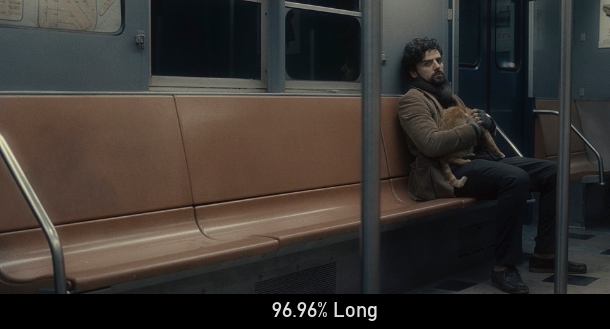

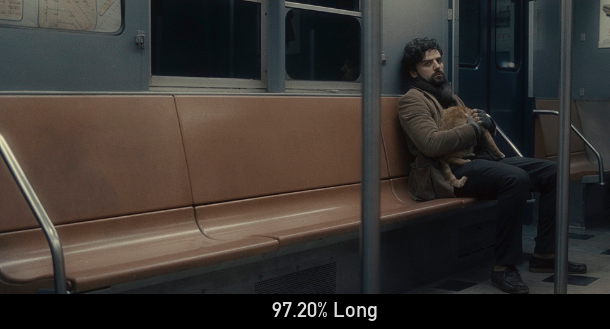

In [ ]:
#predict = Predictor(learn.model, nn.Softmax(-1), classes=list(learn.dls.vocab), top_k=4)

#predict.pretty_predict_str(f, top_k=3, pretty_predictor=pretty_predictor)

f = np.random.choice(files)
predict_noblur.pretty_predict(f, pretty_predictor, top_k=1)
predict_blur.pretty_predict(f, pretty_predictor, top_k=1)

In [ ]:
predict_blur


     Model Taxonomy
-------------------------
01-extremewide
02-wide
03-long
04-medium_long
05-medium
06-medium-close-up
07-closeup-face
09-cu-ecu-lower-body
10-cu-ecu-object
11-cu-animals-with-eyes
12-extreme-close-up-eyes
13-extreme-close-up-hands
14-extreme-close-up-mouth
15-extreme-close-up-paper
16-zz-NA
        
      Preprocessing
-------------------------
Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

   Activation Function
-------------------------
Softmax(dim=-1)
        

In [ ]:
import av
import math
from tqdm.auto import tqdm

In [ ]:
def round_up(num:float) -> int: return int(math.ceil(num))
def torch_to_numpy(tensor): return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [ ]:
# video_path = '/Users/rahulsomani/Pictures/Edgar-Wright-How-to-Do-Visual-Comedy.webm'
# video_path = '/Users/rahulsomani/Pictures/Zack Snyder’s Justice League _ Sneak Peek _ HBO Max-lPjF9sJcj4A.mp4'
# video_path = '/Users/rahulsomani/Downloads/Edgar Wright - How to Do Visual Comedy.mp4'
# video_path = '/Users/rahulsomani/Desktop/test-videos/profiles___a_tarantino_supercut_123518521.mp4'
# video_path = '/Users/rahulsomani/Desktop/test-videos/lone_figures_155345048.mp4'
# video_path = '/Users/rahulsomani/Desktop/test-videos/loneliness_of_sofia_coppola_122354082.mp4'
# video_path = '/Users/rahulsomani/Desktop/test-videos/The Matrix - Up Close-124381641.mp4'
# video_path = '/Users/rahulsomani/Pictures/2019-Films-In-A-Minute.mp4'
# video_path = '/Users/rahulsomani/Pictures/Halt & Catch Fire Season 1 Trailer-pWrioRji60A.webm'
video_path = '/Users/rahulsomani/Pictures/Utopia Series 1 - Trailer-CBN0XTVfn0E.mp4'

assert Path(video_path).exists()

In [ ]:
#predict = Predictor(old_framing_model, nn.Softmax(-1), classes=old_framing_classes)
#predict = Predictor(learn.model, nn.Softmax(-1), classes=list(learn.dls.vocab), top_k=4)

In [ ]:
video_codec   = 'libx264'
audio_codec   = 'aac'
video_pix_fmt = 'yuv420p'
output_video  = True
output_path   = '/Users/rahulsomani/Desktop/test-results'
prefix        = 'blurring-model__'

input_container  = av.open(video_path)
frame_stride     = 1
if output_video:
    output_fname     = str(f"{prefix}{Path(video_path).stem}-framing_analysis.mp4")
    output_container = av.open(str(Path(output_path)/output_fname), mode='w')
    output_audio_stream = output_container.add_stream(audio_codec)
    output_video_stream = output_container.add_stream(video_codec)



num_frames = round_up(input_container.streams.video[0].frames / frame_stride)
num_frames


1954

In [ ]:
fps = input_container.streams.video[0].average_rate

# Reading, Predicting, and Writing Video Frames
for frame in tqdm(input_container.decode(video=0), total=num_frames if num_frames else None):
    img = frame.to_image()
    pred_img = predict_blur.pretty_predict(img, pretty_predictor, top_k=1)
    
    if output_video:
        output_frame = av.VideoFrame.from_image(pred_img)
        for packet in output_video_stream.encode(output_frame):
            output_container.mux(packet)

# Writing Audio Frames
input_container     = av.open(str(video_path))
input_audio_stream  = input_container.streams.get(audio=0)[0]
input_audio_decoder = input_container.decode(input_audio_stream)

for frame in input_audio_decoder:
    frame.pts = None
    for packet in output_audio_stream.encode(frame):
        output_container.mux(packet)

output_container.close()
input_container.close()

In [ ]:
output_fname

'Zack Snyder’s Justice League _ Sneak Peek _ HBO Max-lPjF9sJcj4A-framing_analysis.mp4'